<a href="https://colab.research.google.com/github/abhijeetk597/PyTorch-Practice/blob/main/01_neural_bag_of_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of IMDB movie reviews

In this project we'll be building a machine learning model to perform sentiment analysis where the task is to detect if a given sentence is positive or negative -- using `PyTorch` and `torchtext`. The dataset used will be movie reviews from the IMDB Dataset, which we'll obtain using `datasets` library

## Introduction

In this notebook, we'll start very simple with one of the most basic models for NLP: a NBoW (neural bag-of-words) model (also known as continuous bag-of-words, CBoW). The NBoW model are a strong, commonly used, baseline model for NLP tasks. They should be first models you implement when performing sentiment analysis/text classification.

## Preparing Data

Before we can implement our NBoW model, we first have to perform quite a few steps to get our data ready to use. NLP usually requires quite a lot of data wrangling beforehand, though libraries such as `datasets` and `torchtext` handle most of this for us.

The steps to take are:
- importing modules
- Loading data
- tokenizing data
- creating data splits
- creating a vocabulary
- numericalizing data
- creating the data loaders

## Importing necessary libraries

In [1]:
!pip install -q datasets

In [2]:
import collections

import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

import matplotlib.pyplot as plt
import numpy as np

# set random seed
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Loading the data

We'll load our dataset using the `datasets` library. The first argument is the name of the dataset and the `split` argument chooses which splits of the data we want.

How do we know that we have to use "imdb" for the IMDb dataset and that there's an "unsupervised" split? The datasets library has a great website used to browse the available datasets, see: https://huggingface.co/datasets/. By navigating to the IMDb dataset page we can see more information specifically about the IMDb dataset.

The output received when loading the dataset tells us that it is using a locally cached version instead of downloading the dataset from online.

In [3]:
# import train data and test data from imdb dataset
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

train_data, test_data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

We can check the `features` attribute of a split to get more informationo about the features.

In [4]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

We can see that `text` is a value of `dtype=string` in other words, it's a sting and theat `label` is a `ClassLabel`. A ClassLabel means the feature is an integer representation of which class the example belongs to. `num_classes=2` means that our labels are one of the two values 0 or 1 and `names=['neg', 'pos']` gives us the human readable versions of those values. Thus, a label of 0 means the example is a negative review and a label of 1 means the example is a positive review.

Let's check random instance of our train data.

In [5]:
import random

train_data[random.choice(range(len(train_data)))]

{'text': 'When I first saw a small scene of it in some announcements, I thought the show would be entertaining to watch. The little robot guy does look kinda cute. The style of animation does look sort of familiar to some classic shows. Before the show aired, I studied it through some sources. There, I did became slightly dismayed. The three children (Tommy, Gus and Lola) are voiced appropriately but Robotboy is an exception. It would have been a lot nicer if he were to be portrayed by a young lad. One good example is Robot Jones, a robot character from "Whatever Happened To Robot Jones?" The show isn\'t bad really. But the way Robotboy is inappropriately portrayed is my only criticism. Thus, I don\'t watch it much.',
 'label': 0}

We can notice the presence of escape charactes `\` and html tags `<br>` in our data

### Tokenization

There are many types of tokenizers available, but we're going to use a relatively simple one provided by `torchtext` called the `basic_english`.

In [6]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

`basic_english` tokenizer creates a token by splitting the word on spaces, separating punctuation into its own token and also lowercasing every word.

The `get_tokenizer` function also supports other tokenizers, such as ones provided by **SpaCy** and **nltk**.

In [7]:
tokenizer("Hello world! How are you doing today? I'm doing fantastic!")

['hello',
 'world',
 '!',
 'how',
 'are',
 'you',
 'doing',
 'today',
 '?',
 'i',
 "'",
 'm',
 'doing',
 'fantastic',
 '!']

To tokenize our whole data, we will create a tokenize function and map it to the dataset.

In [8]:
def tokenize_example(example, tokenizer, max_length):
  tokens = tokenizer(example["text"])[:max_length]
  return {"tokens": tokens}

max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
    )

test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
    )

In [9]:
train_data

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 25000
})

In [10]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

- We can now see that our `train_data` has a `tokens` feature.
- By looking at the `features` attribute we can see it has automatically added the information about the tokens feature -- each is a sequence (a list) of strings. A length=-1 means that all of our token sequences are not the same length.

In [11]:
# Check the result of our tokenization
train_data[0]["tokens"][:25]

['i',
 'rented',
 'i',
 'am',
 'curious-yellow',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967',
 '.']

### Creating a validation dataset

In [12]:
val_size = 0.25

train_valid_data = train_data.train_test_split(test_size=val_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

len(train_data), len(valid_data), len(test_data)

(18750, 6250, 25000)

### Creating a vocabulary

Next, we have to build a vocabulary. This is look-up table where every unique token in your dataset has a corresponding *index*.

One issue with creating a vocabulary using every single word in the dataset is that there are usually a considerable amount of unique tokens. One way to combat this is to either only construct the vocabulary only using the most commonly appearing tokens, or to only use tokens which appear a minimum amount of times the dataset. In this notebook, we do the latterr, keeping on tokens which appear at least 5 times.

What happens to tokens which appear less than 5 times? We replace them with a special unknown token, denoted by `<unk>`.

We use the `build_vocab_from_iterator` function from `torchtext.vocab` to create our vocabulary, specifying the `min_freq` and `special_tokens`.

The first special token is our unkown token, the other, `<pad>` is a special token we'll use for padding sentences.

In [13]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens
)

In [14]:
# check length of the vocabulary
len(vocab)

21528

In [15]:
# get 10 most frequent tokens
vocab.get_itos()[:10]

['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'"]

We can get the index of a token by accessing it like a dictionary

In [16]:
vocab["and"]

6

We store the indices of the unknown and padding tokens (zero and one, respectively) in variables, as we'll use these further on in this notebook.

In [17]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

We can check if a token is in our vocabulary using the `in` operator

In [18]:
"some_token" in vocab, "best" in vocab, "enjoyed" in vocab

(False, True, True)

By default, a vocabulary created by `torchtext` will throw an error if you attempt to obtain the index of a token which is not in the vocabulary ie. `vocab["some_token"]` will throw an error.

We need to explicitly tell the vocabulary which token to return if we pass a token not in the vocabulary. We do this using `set_default_index` method, passing in the index we wish it to return. Here, we pass the index of the unknown token.

In [19]:
vocab.set_default_index(unk_index)

vocab["some_token"]

0

To look-up a list of tokens, we can use the vocabulary's `lookup_indices` method.

In [20]:
vocab.lookup_indices(["hello", "world", "some_token", "<pad>"])

[4602, 186, 0, 1]

### Numericalizing data

Now we have our vocabulary, we can numericalize our data. This involves converting the tokens within our dataset into indices. Similar to how we tokenized our data using the `Dataset.map` method, we'll define a function that takes an example and our vocabulary, gets the index for each token in each example and then creates and `ids` field which contains the numericalized tokens.

In [21]:
def numericalize_example(example, vocab):
  ids = vocab.lookup_indices(example["tokens"])
  return {"ids": ids}

# map this function to our train, val and test data
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

In [22]:
print("----Tokens:----")
print(train_data[2]["tokens"][:10])
print("\n----Lookup indices:----")
print(vocab.lookup_indices(train_data[2]["tokens"][:10]))
print("\n----ids:----")
print(train_data[2]["ids"][:10])

----Tokens:----
['i', 'don', "'", 't', 'know', 'why', 'some', 'people', 'criticise', 'that']

----Lookup indices:----
[12, 90, 9, 28, 130, 142, 55, 83, 12619, 15]

----ids:----
[12, 90, 9, 28, 130, 142, 55, 83, 12619, 15]


The final step of numericalizing is transforming the `ids` and `label` from integers into `PyTorch` tensors, which we do using the `with_format` method.

In [23]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

train_data[0]["label"], train_data[0]["ids"][:10]

(tensor(1),
 tensor([  54,   10,   43, 6009,   47,  124,   57,   36,   83,  324]))

One thing to note that when using `with_format`, all the columns not specified ("tokens" and "text") are removed from the example.

In [24]:
train_data[0].keys()

dict_keys(['label', 'ids'])

Removing the "tokens" field is fine, as if we wanted to retrieve the human-readable tokens again we can simply convert the tensor into a Python list of integers and then use the vocabulary's `lookup_tokens` method.

In [25]:
vocab.lookup_tokens(train_data[0]["ids"][:10].tolist())

['what', 'is', 'so', 'taboo', 'about', 'love', '?', '!', 'people', 'seem']

## Creating Data Loaders

The final step of preparing the data is creating the data loaders. We can iterate over a data loader to retrive batches of examples. This is also where we will perform any padding that is necessary.

We first need to define a function to *collate* batch, consisting of a list of examples, into what we want our data loader to output.

Here, our desired output from the data loader is a dictionary with keys of "ids" and "label".

The value of `batch["ids"]` should be a tensor of shape [batch size, length], where length is the length of the longest sentence (in terms of tokens) within the batch, and all sentences shorter than this should be padded to that length.

The values of `batch["label"]` should be a tensor of shape `[batch_size]` consisting of the label for each sentence in the batch.

We define a function, `get_collate_fn`, which is passed the pad token index and returns the actual collate function. Within the actual collate function, `collate_fn`, we get a list of "ids" tensors for each example in the batch, and then use the `pad_sequence` function, which converts the list of tensors into the desired `[batch_size, length]` shaped tensor and performs padding using the specified `pad_index`. By default, `pad_sequence` will return a `[length, batch_size]` shaped tensor, but by setting `batch_first`=True, these two dimensions are switched. We get a list of "label" tensors and convert the list of tensors into a single `[batch_size]` shaped tensor.

In [26]:
def get_collate_fn(pad_index):
  def collate_fn(batch):
    batch_ids = [i["ids"] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(
        batch_ids, padding_value=pad_index, batch_first=True
    )
    batch_label = [i["label"] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {"ids": batch_ids, "label": batch_label}
    return batch

  return collate_fn

Now, we define a function which returns our actual data loader. It takes in a dataset, desired batch size (the number of sentences we want in a batch), our padding token index, and if the dataset should be shuffled.

In [27]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
  collate_fn = get_collate_fn(pad_index)
  data_loader = torch.utils.data.DataLoader(
      dataset=dataset,
      batch_size=batch_size,
      collate_fn=collate_fn,
      shuffle=shuffle
  )
  return data_loader

Finally, we get the data loaders for the training, validation and test data.

We set the batch size equal to 512. Our batch size should be set as high as we can, as larger batches means more parallel computaion, less compute time, and thus faster training and evaluation.

Only the training data loader needs to be shuffled, as it's the only one used to actually tune the parameters within the model.

In [28]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [29]:
list(train_data_loader)[0]

{'ids': tensor([[   14,   359,    10,  ...,     1,     1,     1],
         [    0,    10,    41,  ...,    76,     5,   992],
         [   26,    95,   883,  ...,    38,     2,   147],
         ...,
         [18297,    15,    10,  ...,     1,     1,     1],
         [   14,    23,    72,  ...,  2364,    44,     5],
         [   52,    26,    74,  ...,     1,     1,     1]]),
 'label': tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
         0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
         0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
         0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
         1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
         0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
         0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,

## Building the model

In [30]:
class NBoW(nn.Module):
  def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
    self.fc = nn.Linear(embedding_dim, output_dim)

  def forward(self, ids):
    # embedded = self.embedding(ids)
    # pooled = embedded.mean(dim=1)
    # prediction = self.fc(pooled)
    # return prediction
    return self.fc((self.embedding(ids).mean(dim=1)))

In [31]:
vocab_size = len(vocab)
embedding_dim = 300
output_dim = len(train_data.unique("label"))

model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [32]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model): } trainable parameters")

The model has  6459002 trainable parameters


In [33]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)
criterion = criterion.to(device)

cuda


In [34]:
def train(data_loader, model, criterion, optimizer, device):
  model.train()
  epoch_losses = []
  epoch_accs = []
  for batch in tqdm.tqdm(data_loader, desc="training..."):
    ids = batch["ids"].to(device)
    label = batch["label"].to(device)
    prediction = model(ids)
    loss = criterion(prediction, label)
    accuracy = get_accuracy(prediction, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
    epoch_accs.append(accuracy.item())
  return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(data_loader, model, criterion, device):
  model.eval()
  epoch_losses = []
  epoch_accs = []
  with torch.no_grad():
    for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
      ids = batch["ids"].to(device)
      label = batch["label"].to(device)
      prediction = model(ids)
      loss = criterion(prediction, label)
      accuracy = get_accuracy(prediction, label)
      epoch_losses.append(loss.item())
      epoch_accs.append(accuracy.item())
  return np.mean(epoch_losses), np.mean(epoch_accs)

def get_accuracy(prediction, label):
  batch_size, _ = prediction.shape
  predicted_classes = prediction.argmax(dim=-1)
  correct_predictions = predicted_classes.eq(label).sum()
  accuracy = correct_predictions / batch_size
  return accuracy

In [35]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
  train_loss, train_acc = train(
      train_data_loader, model, criterion, optimizer, device
  )
  valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
  metrics["train_losses"].append(train_loss)
  metrics["train_accs"].append(train_acc)
  metrics["valid_losses"].append(valid_loss)
  metrics["valid_accs"].append(valid_acc)
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), "nbow.pth")
  print(f"epoch: {epoch}")
  print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
  print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 13/13 [00:00<00:00, 49.14it/s]


epoch: 0
train_loss: 0.678, train_acc: 0.619
valid_loss: 0.662, valid_acc: 0.658


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 19.00it/s]


epoch: 1
train_loss: 0.643, train_acc: 0.686
valid_loss: 0.623, valid_acc: 0.701


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  9.39it/s]


epoch: 2
train_loss: 0.594, train_acc: 0.734
valid_loss: 0.574, valid_acc: 0.752


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 51.16it/s]


epoch: 3
train_loss: 0.536, train_acc: 0.781
valid_loss: 0.521, valid_acc: 0.789


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 49.46it/s]


epoch: 4
train_loss: 0.478, train_acc: 0.815
valid_loss: 0.474, valid_acc: 0.816


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 51.42it/s]


epoch: 5
train_loss: 0.427, train_acc: 0.840
valid_loss: 0.436, valid_acc: 0.832


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 49.99it/s]


epoch: 6
train_loss: 0.384, train_acc: 0.860
valid_loss: 0.407, valid_acc: 0.845


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 48.36it/s]


epoch: 7
train_loss: 0.348, train_acc: 0.876
valid_loss: 0.383, valid_acc: 0.854


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 49.33it/s]


epoch: 8
train_loss: 0.318, train_acc: 0.887
valid_loss: 0.365, valid_acc: 0.857


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 34.24it/s]


epoch: 9
train_loss: 0.293, train_acc: 0.900
valid_loss: 0.349, valid_acc: 0.865


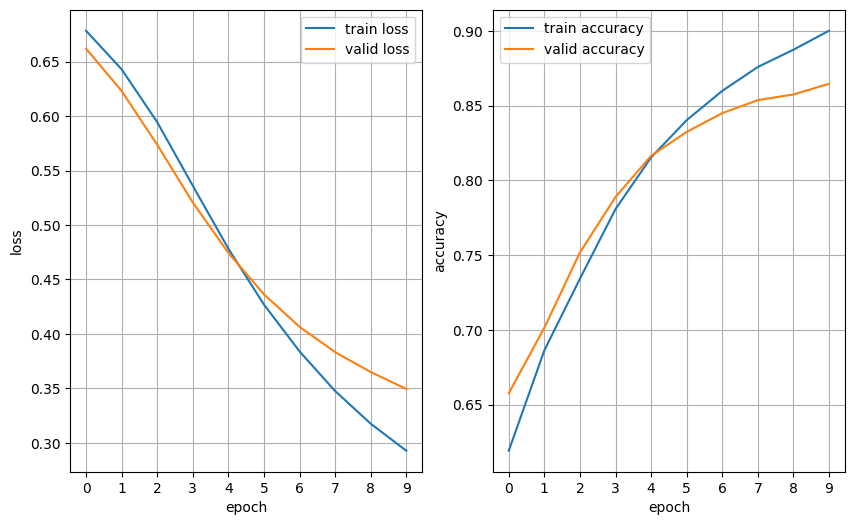

In [36]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()
ax = fig.add_subplot(1, 2, 2)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [37]:
model.load_state_dict(torch.load("nbow.pth"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 49/49 [00:01<00:00, 42.31it/s]


In [38]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.371, test_acc: 0.845


In [39]:
def predict_sentiment(text, model, tokenizer, vocab, device):
  tokens = tokenizer(text)
  ids = vocab.lookup_indices(tokens)
  tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
  prediction = model(tensor).squeeze(dim=0)
  probability = torch.softmax(prediction, dim=-1)
  predicted_class = prediction.argmax(dim=-1).item()
  predicted_probability = probability[predicted_class].item()
  return predicted_class, predicted_probability

In [40]:
text = "This is an excellent movie"
predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9998527765274048)

In [42]:
text1 = "This film is terrible"
predict_sentiment(text1, model, tokenizer, vocab, device)

(0, 0.9999998807907104)

In [43]:
text2 = "This film is not terrible, it's great!"
predict_sentiment(text2, model, tokenizer, vocab, device)

(1, 0.8932341933250427)

In [44]:
text3 = "This film is not great, it's terrible!"

predict_sentiment(text3, model, tokenizer, vocab, device)

(1, 0.8932343125343323)